In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solar-powe-generation-data/Solar Power Plant Data.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from xgboost import plot_importance
%matplotlib inline

## Reading the dataset into a dataframe

In [3]:
df = pd.read_csv('/kaggle/input/solar-powe-generation-data/Solar Power Plant Data.csv')

In [4]:
# inspecting the dataframe
df.head()

,Date-Hour(NMT),WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,01.01.2017-00:00,0.6,0,1003.8,-7.4,0.1,97,0.0
1,01.01.2017-01:00,1.7,0,1003.5,-7.4,-0.2,98,0.0
2,01.01.2017-02:00,0.6,0,1003.4,-6.7,-1.2,99,0.0
3,01.01.2017-03:00,2.4,0,1003.3,-7.2,-1.3,99,0.0
4,01.01.2017-04:00,4.0,0,1003.1,-6.3,3.6,67,0.0


In [5]:
print(f'The data frame has {df.shape[0] } rows and {df.shape[1]} columns')

The data frame has 8760 rows and 8 columns


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date-Hour(NMT)       8760 non-null   object 
 1   WindSpeed            8760 non-null   float64
 2   Sunshine             8760 non-null   int64  
 3   AirPressure          8760 non-null   float64
 4   Radiation            8760 non-null   float64
 5   AirTemperature       8760 non-null   float64
 6   RelativeAirHumidity  8760 non-null   int64  
 7   SystemProduction     8760 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 547.6+ KB


## Descriptive Statistics

In [7]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date-Hour(NMT),8760,8760,01.01.2017-00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WindSpeed,8760.0,NaN,NaN,NaN,2.639823,1.628754,0.0,1.4,2.3,3.6,10.9
Sunshine,8760.0,NaN,NaN,NaN,11.180479,21.171295,0.0,0.0,0.0,7.0,60.0
AirPressure,8760.0,NaN,NaN,NaN,1010.361781,12.793971,965.9,1002.8,1011.0,1018.2,1047.3
Radiation,8760.0,NaN,NaN,NaN,97.538493,182.336029,-9.3,-6.2,-1.4,115.6,899.7
AirTemperature,8760.0,NaN,NaN,NaN,6.978893,7.604266,-12.4,0.5,6.4,13.4,27.1
RelativeAirHumidity,8760.0,NaN,NaN,NaN,76.719406,19.278996,13.0,64.0,82.0,93.0,100.0
SystemProduction,8760.0,NaN,NaN,NaN,684.746071,1487.454665,0.0,0.0,0.0,464.24995,7701.0


The **Date-Hour** column would be renamed and set as the index of the dataframe because this is a time series problem.

In [8]:
# renaming the column
df.rename(columns = {'Date-Hour(NMT)' : 'Datetime'}, inplace = True)

# setting the index
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index,
                         infer_datetime_format = True)

In [9]:
df.head(3)

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
Datetime,,,,,,,
2017-01-01 00:00:00,0.6,0,1003.8,-7.4,0.1,97,0.0
2017-01-01 01:00:00,1.7,0,1003.5,-7.4,-0.2,98,0.0
2017-01-01 02:00:00,0.6,0,1003.4,-6.7,-1.2,99,0.0


### Visualizing target distribution over the time frame.

Text(0.5, 1.0, 'Total Power production 2017')

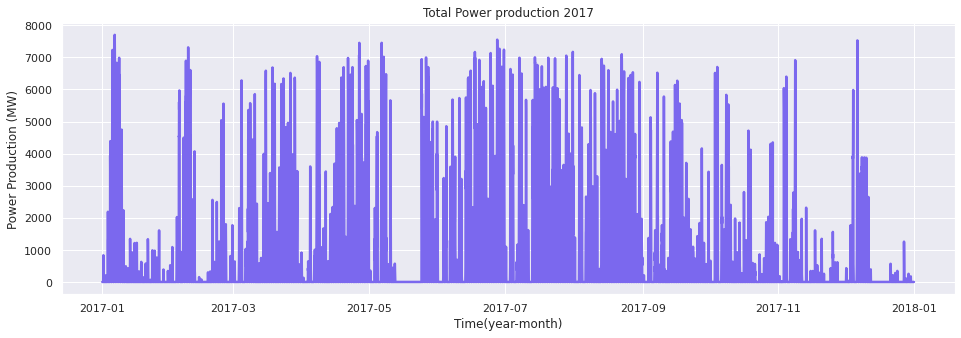

In [10]:
sns.set()
plt.figure(figsize=(16, 5))
sns.lineplot(x = df.index,
            y = 'SystemProduction',
            data = df, linewidth = 2.5, color = 'mediumslateblue')
plt.xlabel('Time(year-month)')
plt.ylabel('Power Production (MW)')
plt.title('Total Power production 2017')

## Univariate analysis

<AxesSubplot:xlabel='RelativeAirHumidity', ylabel='Count'>

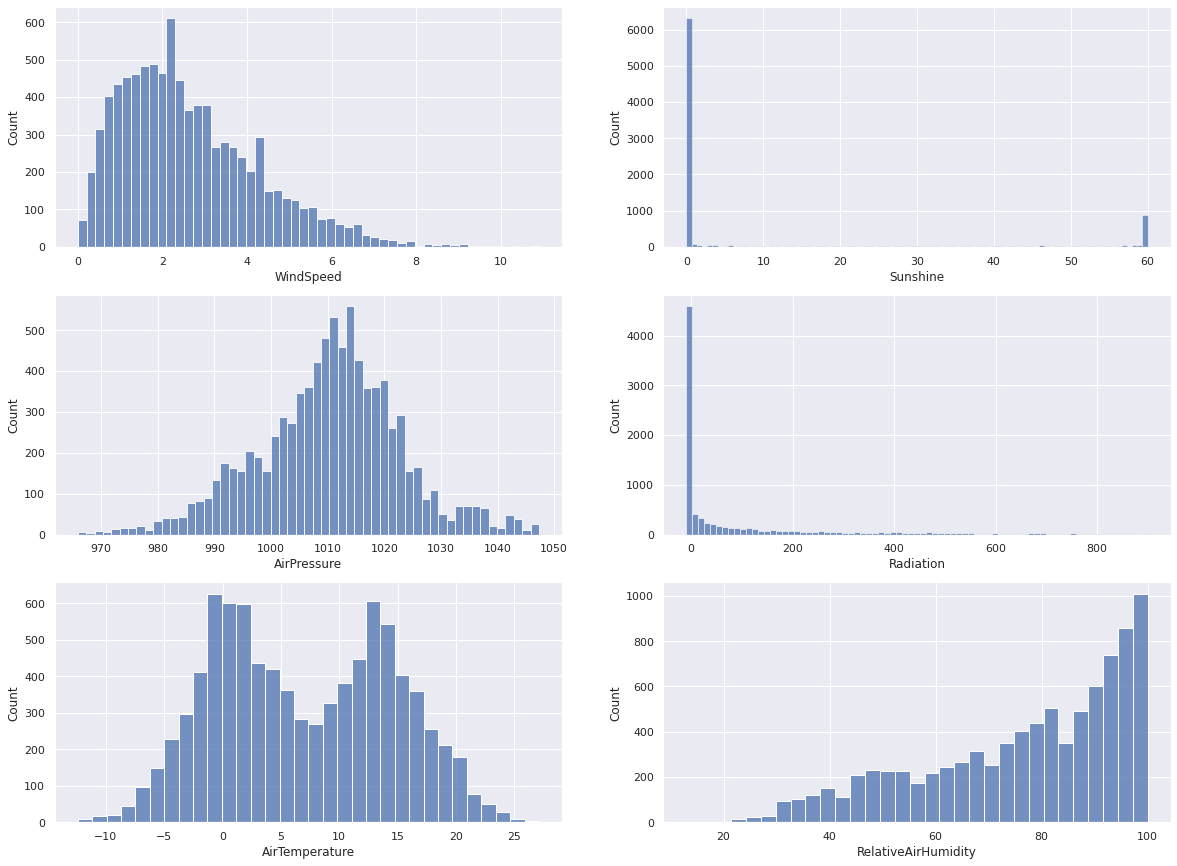

In [11]:
sns.set()
fig, axes = plt.subplots(3, 2, figsize = (20, 15))

# creating histograms for each independent variable to assess the distribution

sns.histplot(data= df, x= 'WindSpeed', ax= axes[0, 0])
sns.histplot(data= df, x= 'Sunshine', ax= axes[0, 1])
sns.histplot(data= df, x= 'AirPressure', ax= axes[1, 0])
sns.histplot(data= df, x= 'Radiation', ax= axes[1, 1])
sns.histplot(data= df, x= 'AirTemperature', ax= axes[2, 0])
sns.histplot(data= df, x= 'RelativeAirHumidity', ax = axes[2, 1])


## Feature engineering

In [12]:
def create_features(df):
    '''create time series features from the index '''
    
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    
    return df

create_features(df)
df.head(4)

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,hour,day_of_week,quarter,month,day_of_month,day_of_year,week_of_year
Datetime,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.6,0,1003.8,-7.4,0.1,97,0.0,0,6,1,1,1,1,52
2017-01-01 01:00:00,1.7,0,1003.5,-7.4,-0.2,98,0.0,1,6,1,1,1,1,52
2017-01-01 02:00:00,0.6,0,1003.4,-6.7,-1.2,99,0.0,2,6,1,1,1,1,52
2017-01-01 03:00:00,2.4,0,1003.3,-7.2,-1.3,99,0.0,3,6,1,1,1,1,52


In [13]:
train = df.loc[df.index < '2017-10-01'] # train feature dataframe
test = df.loc[df.index >= '2017-10-01'] # test feature dataframe

# training set
X_train = train.drop(columns = ['SystemProduction'])
y_train = train['SystemProduction'] # target variable

# test dataframe
X_test = test.drop(columns = ['SystemProduction'])
y_test = test['SystemProduction'] # target variable 

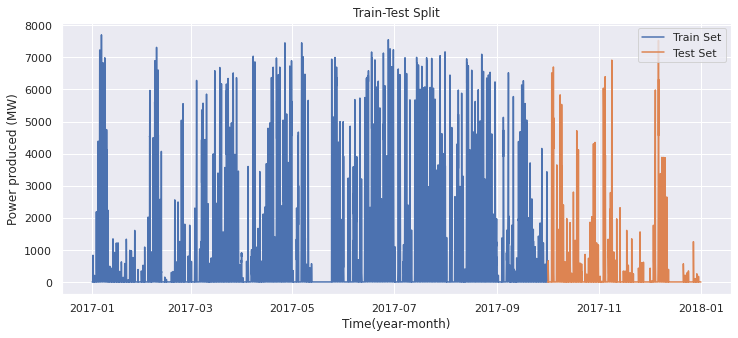

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(x = train.index, y = 'SystemProduction', data = train)
sns.lineplot(x = test.index, y = 'SystemProduction', data = test)

plt.title('Train-Test Split')
plt.ylabel('Power produced (MW)')
plt.xlabel('Time(year-month)')
ax.legend(['Train Set', 'Test Set'])
plt.show()

Visualizing one week of power production

Text(0.5, 1.0, 'First week power production')

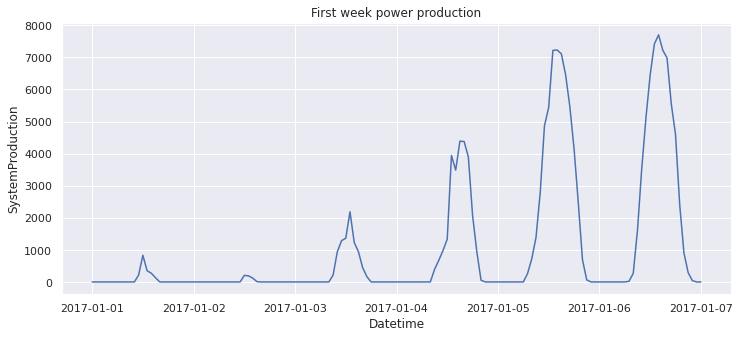

In [15]:
_ = df.loc[df.index <= '2017-01-07']
plt.subplots(figsize=(12, 5))
sns.lineplot(x = _.index, y = 'SystemProduction', data = _)
plt.title('First week power production')

This plot shows an upward trend in power produced as the week wears on. Low levels of energy production in this first week could be alluded to the winter season.

Applying the function to the dataframe

### Power production over a 24 hour period.

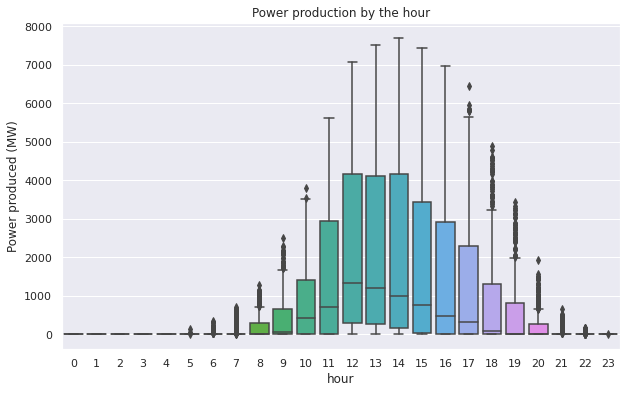

In [16]:
sns.set()
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x = 'hour',
           y = 'SystemProduction',
           data = df)
plt.ylabel('Power produced (MW)')
plt.title('Power production by the hour')
plt.show()

From the chart, we see that power production starts around 08:00 hours and peaks around 12:00 hours, before dropping off again at 21:00 hours

### Power production per month over the year.


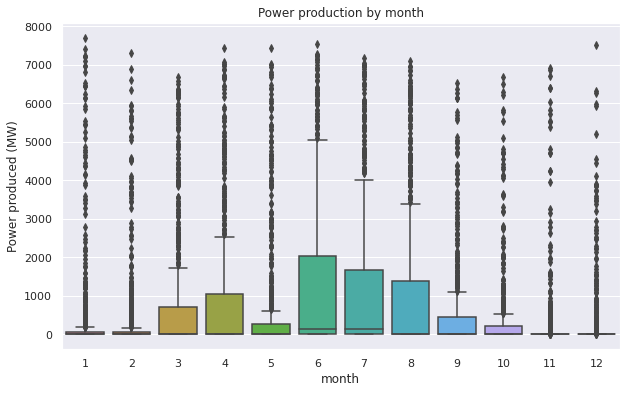

In [17]:
sns.set()
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x = 'month',
           y = 'SystemProduction',
           data = df)
plt.ylabel('Power produced (MW)')
plt.title('Power production by month')
plt.show()

Production of solar energy is low from November through February. This makes sense as that is winter season, so the sun isn't out a lot during that time. Power production is very high during the summer i.e between June and August.

## Creating the model

In [18]:
X_train.dtypes

WindSpeed              float64
Sunshine                 int64
AirPressure            float64
Radiation              float64
AirTemperature         float64
RelativeAirHumidity      int64
hour                     int64
day_of_week              int64
quarter                  int64
month                    int64
day_of_month             int64
day_of_year              int64
week_of_year            UInt32
dtype: object

Changing the **week_of_year** column in the train and test set to float type, so that the model would have no problems parsing it.

In [19]:
X_train['week_of_year'] = X_train['week_of_year'].astype(np.float64)
X_test['week_of_year'] = X_test['week_of_year'].astype(np.float64)

## Modeling

In [20]:
parameters = {'n_estimators': [5, 10, 100, 1000],
             'max_depth': [2, 4, 6, 8],
             'learning_rate': [0.01, 0.1, 1],
              'max_leaves': [2, 4, 6, 8]
             }

Defining the model

In [21]:
model = XGBRegressor()
clf = GridSearchCV(model, parameters, n_jobs = 5, scoring = 'neg_mean_squared_error')

In [22]:
clf.fit(X_train, y_train) #fit the model t the train data

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_o...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None,

In [23]:
print('best parameters: ', clf.best_params_)
print('best score: ', clf.best_score_)

best parameters:  {'learning_rate': 0.01, 'max_depth': 2, 'max_leaves': 2, 'n_estimators': 1000}
best score:  -1100479.7386493231


In [24]:
parameters = {'learning_rate': [0.01], 
              'max_depth': [2], 
              'max_leaves': [2], 
              'n_estimators': [1000]}
model = XGBRegressor()
clf = GridSearchCV(model, parameters, n_jobs = 5, scoring = 'neg_mean_squared_error')
clf.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_o...None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=

Making predictions

In [25]:
# Predictions
y_preds = clf.predict(X_test)
y_preds[0:5]

array([3.1170752, 4.5211687, 4.5211687, 4.5211687, 4.5211687],
      dtype=float32)

In [26]:
print(mean_absolute_error(y_test, y_preds))

214.70608777865783


## Plot feature Importance

In [29]:
xgb = XGBRegressor(learning_rate= 0.01, 
              max_depth= 2, 
              max_leaves = 2, 
              n_estimators = 1000)
xgb.fit(X_train, y_train)
print(xgb.feature_importances_)

[0.00754434 0.01414702 0.02152656 0.49117908 0.09142839 0.03488938
 0.18607625 0.         0.00056145 0.02968055 0.08297654 0.02690915
 0.01308128]


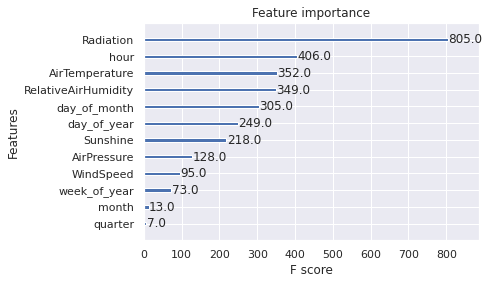

In [31]:
plot_importance(xgb)
plt.show()

I would choose the top four most important features to see if the error would reduce.

In [51]:
f_cols = ["Radiation", "hour", "AirTemperature", "RelativeAirHumidity"] # important features
f_train = train[f_cols]
y_1 = y_train.copy()
f_test = test[f_cols]
y_2 = y_test.copy()
xgb_1 = XGBRegressor().fit(f_train, y_1)
f_preds = xgb_1.predict(f_test)
print(f"The mean absolute error is {mean_absolute_error(f_preds, y_2)}")

The mean absolute error is 184.6016487768262


The mean absolute error has reduced by more than 26MW

## Visualizing the predictions on the hold out test set

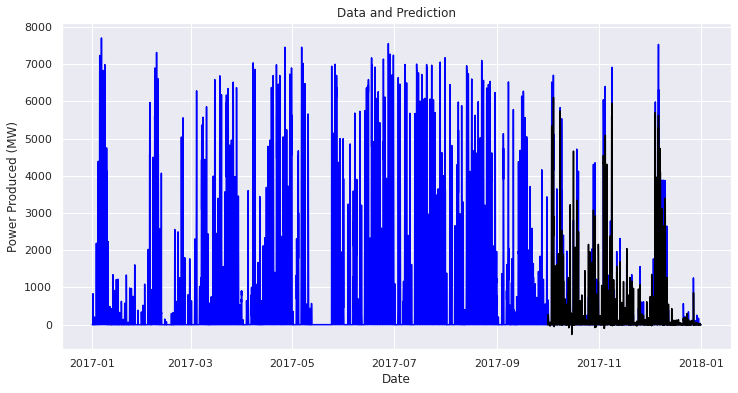

In [52]:
sns.set()
plt.figure(figsize=(12, 6))
sns.lineplot(x= df.index, y = 'SystemProduction', data=df, color = 'blue') #test data 
sns.lineplot(x = f_test.index, y = f_preds, color = 'black') # predictions
plt.title('Data and Prediction')
plt.ylabel('Power Produced (MW)')
plt.xlabel('Date')
plt.show()

## Visualizing predictions of one week with test data

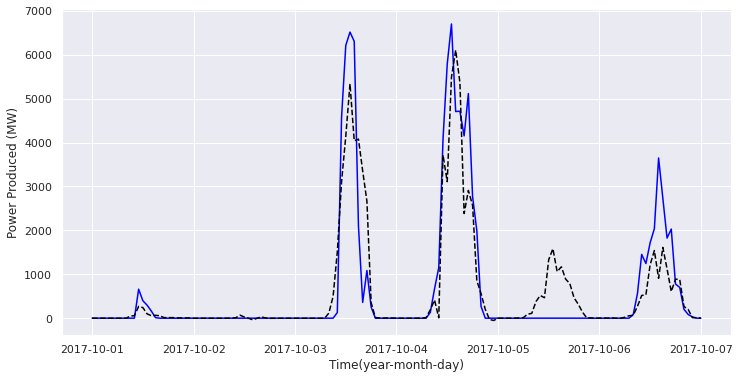

In [53]:
# making a copy of test set
test_copy = test.copy()


# adding predictions to the dataframe
test_copy['predictions'] = f_preds


# slicing a week of the data set
fw = test_copy.loc[(test_copy.index <= '2017-10-07')]


# Plotting

sns.set()
plt.figure(figsize=(12, 6))
sns.lineplot(data = fw, x = fw.index, y='SystemProduction', color = 'blue') # actual values
sns.lineplot(data = fw, x = fw.index, y = 'predictions', color = 'black', linestyle = 'dashed') # predicted values
plt.ylabel('Power Produced (MW)')
plt.xlabel('Time(year-month-day)')
plt.show()

From the plot, it can be obsrved that the model did not perform so great because power production should be 0 at the ebeginning of a new day.

## Visualizing a month of predictions

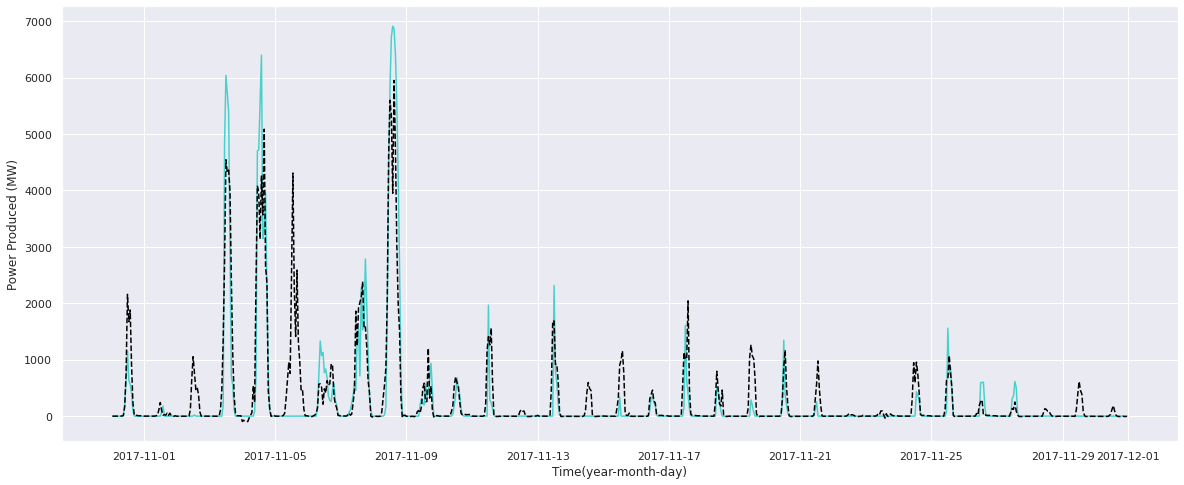

In [54]:
# slicing a week of the data set
fm = test_copy.loc[(test_copy.index > '2017-10-31') & (test_copy.index < '2017-12-01')]


# Plotting

sns.set()
plt.figure(figsize=(20, 8))
sns.lineplot(data = fm, x = fm.index, y='SystemProduction', color = 'mediumturquoise') # actual values
sns.lineplot(data = fm, x = fm.index, y = 'predictions', color = 'black', linestyle = 'dashed') # predicted values
plt.ylabel('Power Produced (MW)')
plt.xlabel('Time(year-month-day)')
plt.show()

## Thoughts
The modelling could be better by:
* Adding lag and shift features.
* Using other time modelling techniques like AutoRegression, MovingAverage, AutoRegressiveIntegratedMovingAverage (ARIMA) etc.